In [ ]:
import os
import re
import json
from glob import glob
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from multiprocessing import Manager

import numpy as np
import pandas as pd
import cv2
import scipy.ndimage
from pycocotools import _mask

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import json
import pandas as pd

with open('/content/_annotations.coco.json', 'r') as f:
    data = json.load(f)

# Extract image and annotation information
images = data['images']
annotations = data['annotations']
categories = data['categories']

# Create lists to store the extracted data
image_ids = []
file_names = []
widths = []
heights = []
category_ids = []
bboxes = []
segmentations = []  # Add a list to store segmentations

# Iterate through the annotations and extract the data
for annotation in annotations:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    bbox = annotation['bbox']
    segmentation = annotation['segmentation']  # Extract segmentation

    # Find the corresponding image information
    image_info = next((img for img in images if img['id'] == image_id), None)
    if image_info:
        file_name = image_info['file_name']
        width = image_info['width']
        height = image_info['height']

        # Append the data to the lists
        image_ids.append(image_id)
        file_names.append(file_name)
        widths.append(width)
        heights.append(height)
        category_ids.append(category_id)
        bboxes.append(bbox)
        segmentations.append(segmentation)  # Append segmentation

# Create a Pandas DataFrame
df = pd.DataFrame({
    'image_id': image_ids,
    'file_name': file_names,
    'width': widths,
    'height': heights,
    'category_id': category_ids,
    'bbox': bboxes,
    'segmentation': segmentations  # Add segmentation column
})

# Create a dictionary to map category IDs to names
category_id_to_name = {category['id']: category['name'] for category in categories}

# Add a new column with the category names
df['category_name'] = df['category_id'].map(category_id_to_name)

# Save the DataFrame to a CSV file
df.to_csv('annotations_seg.csv', index=False)

In [ ]:
df.head()

,image_id,file_name,width,height,category_id,bbox,segmentation,category_name
0,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[531, 603, 71, 36]","[[554, 614, 540, 604, 531, 603, 531, 614, 538,...",rice blast
1,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[75, 233, 151, 132]","[[75, 233, 88, 265, 175, 354, 192, 365, 226, 3...",leaf blight
2,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[31, 61, 321, 145]","[[352, 66, 340, 61, 261, 99, 204, 119, 117, 14...",leaf blight
3,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[174, 140, 80.668, 25.584]","[[217.115, 140.109, 189.838, 144.769, 173.804,...",rice blast
4,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,1,"[143, 388, 72, 25]","[[164, 388, 150, 390, 145, 395, 143, 402, 152,...",grain discoloration


In [ ]:
df['segmentation'][0]

[[554,
  614,
  540,
  604,
  531,
  603,
  531,
  614,
  538,
  625,
  557,
  639,
  602,
  639,
  581,
  626,
  554,
  614]]


annotation_count
----------------
leaf blight | Mean: 9.00, Median: 7.00, Std: 7.42, Min: 1.00, Max: 46.00
rice blast | Mean: 10.49, Median: 7.00, Std: 9.74, Min: 1.00, Max: 52.00
pesticide residue | Mean: 23.32, Median: 22.00, Std: 14.20, Min: 2.00, Max: 66.00
grain discoloration | Mean: 5.24, Median: 3.00, Std: 5.70, Min: 1.00, Max: 25.00


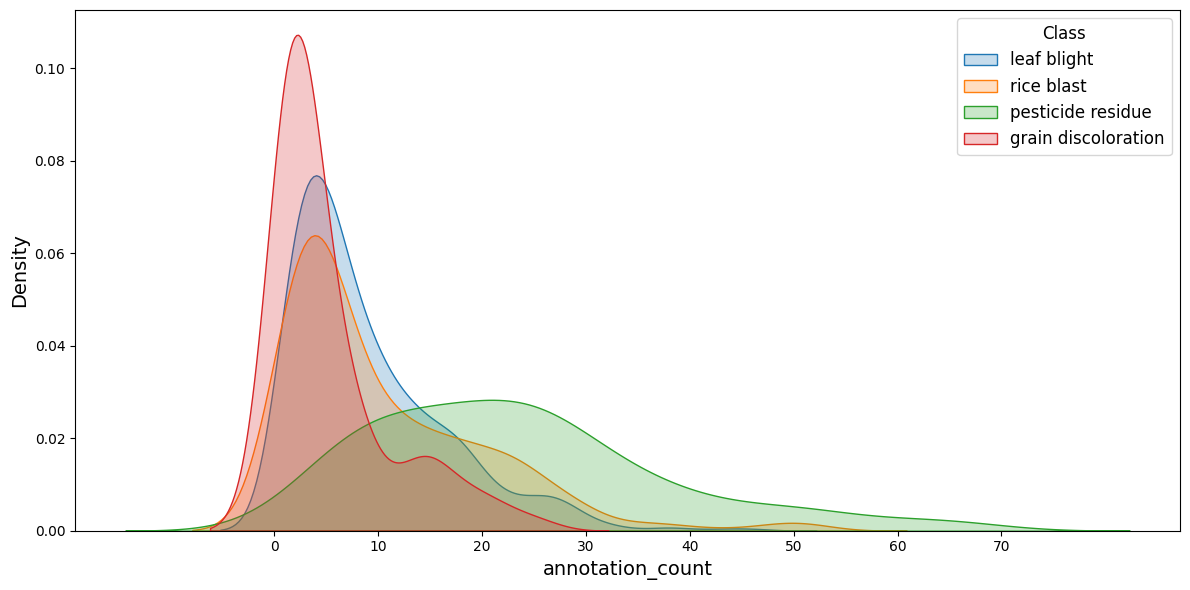

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dữ liệu
df = pd.read_csv('/content/annotations.csv')

# 2. Tính các feature
# 2.1 annotation_count: số instance mỗi ảnh
annotation_counts = df.groupby('file_name').size().rename('annotation_count')
# 2.2 bbox_area: diện tích bounding-box
# df['bbox'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
# Gộp annotation_count về df chính
df = df.merge(annotation_counts, on='file_name')

def visualize_feature_kde_by_class(df, feature, title):
    """
    Vẽ KDE distribution cho feature, tách theo class.
    Nếu feature là 'annotation_count', dùng per-image (dedup bằng groupby).
    Ngược lại dùng per-annotation.
    """
    # Chuẩn bị DataFrame để plot
    if feature == 'annotation_count':
        df_plot = df.groupby('file_name').first().reset_index()
    else:
        df_plot = df.copy()

    classes = df_plot['category_name'].unique()

    # In thống kê nhanh
    print(f'\n{feature}\n{"-"*len(feature)}')
    for cls in classes:
        data = pd.to_numeric(df_plot.loc[df_plot['category_name']==cls, feature], errors='coerce').dropna()
        print(f'{cls} | Mean: {data.mean():.2f}, Median: {data.median():.2f}, '
              f'Std: {data.std():.2f}, Min: {data.min():.2f}, Max: {data.max():.2f}')

    # Vẽ KDE
    plt.figure(figsize=(12, 6))
    for cls in classes:
        data = pd.to_numeric(df_plot.loc[df_plot['category_name']==cls, feature], errors='coerce').dropna()
        sns.kdeplot(data=data, label=cls, fill=True)

    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Class', fontsize=12, title_fontsize=12)
    # **Add x-axis ticks**
    max_value = int(df_plot[feature].max())  # Get the maximum value of the feature
    x_ticks = np.arange(0, max_value + 10, 10)  # Create ticks from 0 to max + 10, step 10
    plt.xticks(x_ticks)
    plt.tight_layout()
    plt.show()


# 3. Chạy vẽ cho các feature
features = ['annotation_count']
for feat in features:
    visualize_feature_kde_by_class(
        df,
        feature=feat,
        title=f'{feat} KDE Distribution by Class'
    )


<Axes: xlabel='category_name', ylabel='count'>

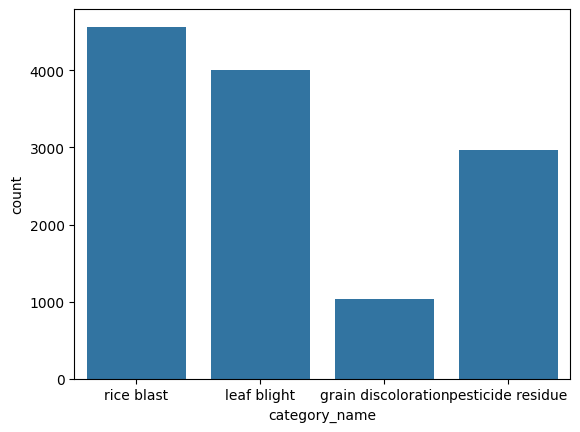

In [ ]:
sns.countplot(data=df, x='category_name')

In [ ]:
def visualize_feature_distribution_for_cell_types(df, feature, title):

    if feature == 'annotation_count' or feature == 'image_mean' or feature == 'image_std':
        df = df.groupby('id').first()

    print(f'{feature}\n{"-" * len(feature)}')
    print(f'cort Mean: {df.loc[df["cell_type"] == "cort"][feature].mean():.4f}  -  Median: {df.loc[df["cell_type"] == "cort"][feature].median():.4f}  -  Std: {df.loc[df["cell_type"] == "cort"][feature].std():.4f} - Min: {df.loc[df["cell_type"] == "cort"][feature].min():.4f} -  Max: {df.loc[df["cell_type"] == "cort"][feature].max():.4f}')
    print(f'shsy5y Mean: {df.loc[df["cell_type"] == "shsy5y"][feature].mean():.4f}  -  Median: {df.loc[df["cell_type"] == "shsy5y"][feature].median():.4f}  -  Std: {df.loc[df["cell_type"] == "shsy5y"][feature].std():.4f} - Min: {df.loc[df["cell_type"] == "shsy5y"][feature].min():.4f} -  Max: {df.loc[df["cell_type"] == "shsy5y"][feature].max():.4f}')
    print(f'astro Mean: {df.loc[df["cell_type"] == "astro"][feature].mean():.4f}  -  Median: {df.loc[df["cell_type"] == "astro"][feature].median():.4f}  -  Std: {df.loc[df["cell_type"] == "astro"][feature].std():.4f} - Min: {df.loc[df["cell_type"] == "astro"][feature].min():.4f} -  Max: {df.loc[df["cell_type"] == "astro"][feature].max():.4f}')

    fig, ax = plt.subplots(figsize=(24, 8), dpi=100)
    sns.kdeplot(df.loc[df['cell_type'] == 'cort'][feature], label='cort', fill=True)
    sns.kdeplot(df.loc[df['cell_type'] == 'shsy5y'][feature], label='shsy5y', fill=True)
    sns.kdeplot(df.loc[df['cell_type'] == 'astro'][feature], label='astro', fill=True)

    ax.legend(prop={'size': 16})
    ax.tick_params(axis='x', labelsize=12.5, pad=10)
    ax.tick_params(axis='y', labelsize=12.5, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title, fontsize=20, pad=15)

    plt.show()


features = ['annotation_count', 'mask_area', 'image_mean', 'image_std']
for feature in features:
    visualize_feature_distribution_for_cell_types(df=df_train, feature=feature, title=f'{feature} Distribution in Training Set')

In [ ]:
df.head()

,image_id,file_name,width,height,category_id,bbox,category_name,annotation_count
0,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[531, 603, 71, 36]",rice blast,12
1,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[75, 233, 151, 132]",leaf blight,12
2,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[31, 61, 321, 145]",leaf blight,12
3,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[174, 140, 80.668, 25.584]",rice blast,12
4,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,1,"[143, 388, 72, 25]",grain discoloration,12


# Countplot số lượng instance theo class

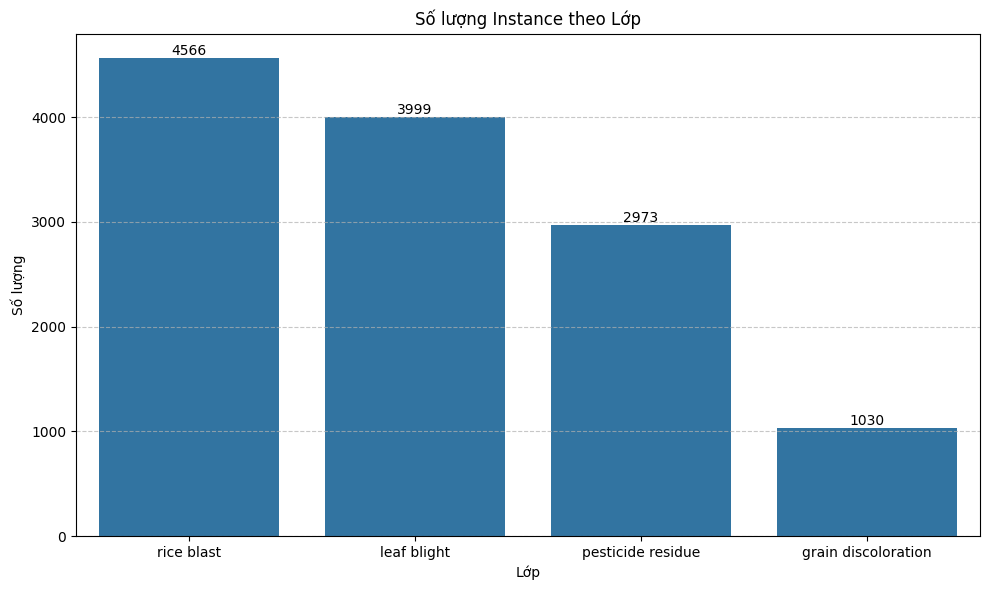

In [ ]:
# Đọc dữ liệu
df = pd.read_csv('annotations_seg.csv')

# Tiền xử lý: tính bbox_area
df['bbox'] = df['bbox'].apply(eval)  # Assuming 'bbox' values are valid list representations
df['bbox_area'] = df['bbox'].apply(lambda x: x[2] * x[3])

# Tính số instance trên mỗi ảnh
annotation_count = df.groupby('file_name').size().reset_index(name='annotation_count')
df = df.merge(annotation_count, on='file_name')

# 1. Countplot số instance theo class
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='category_name', order=df['category_name'].value_counts().index)
ax.set_xlabel("Lớp")
ax.set_ylabel("Số lượng")
# Thêm lưới
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Số lượng Instance theo Lớp')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

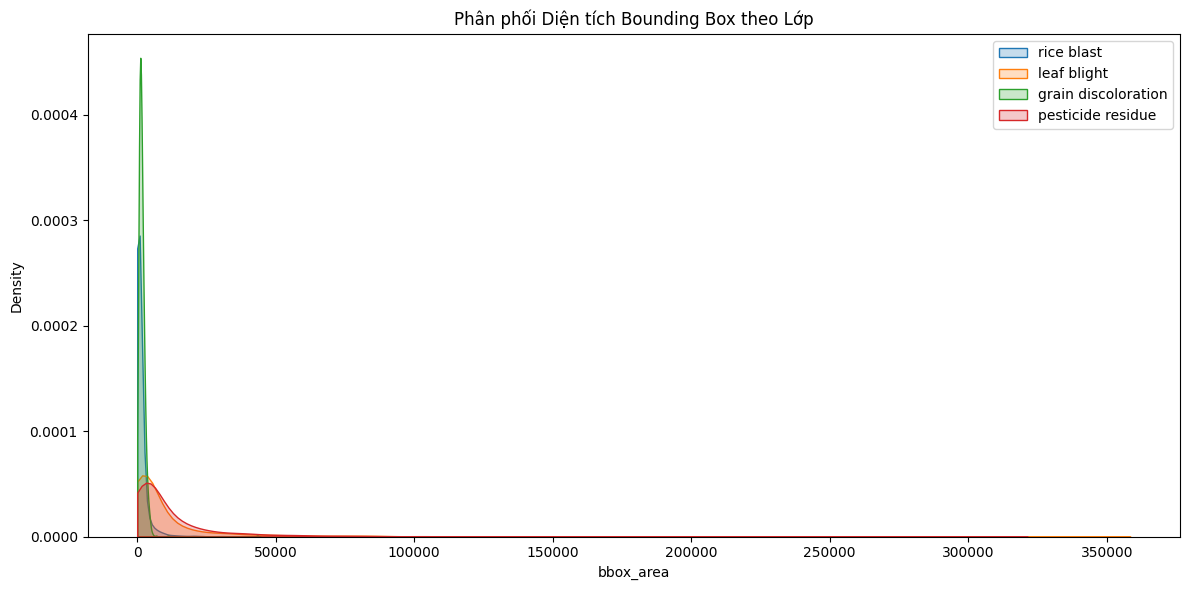

In [ ]:
plt.figure(figsize=(12, 6))
for cls in df['category_name'].unique():
    sns.kdeplot(df[df['category_name'] == cls]['bbox_area'], label=cls, fill=True, clip=(0, None))
plt.title('Phân phối Diện tích Bounding Box theo Lớp')
plt.xlabel('bbox_area')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,image_id,file_name,width,height,category_id,bbox,segmentation,category_name,bbox_area,annotation_count
0,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[531, 603, 71, 36]","[[554, 614, 540, 604, 531, 603, 531, 614, 538,...",rice blast,2556.000000,12
1,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[75, 233, 151, 132]","[[75, 233, 88, 265, 175, 354, 192, 365, 226, 3...",leaf blight,19932.000000,12
2,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,2,"[31, 61, 321, 145]","[[352, 66, 340, 61, 261, 99, 204, 119, 117, 14...",leaf blight,46545.000000,12
3,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,4,"[174, 140, 80.668, 25.584]","[[217.115, 140.109, 189.838, 144.769, 173.804,...",rice blast,2063.810112,12
4,0,ricediseases_1257_jpg.rf.64fb665999d02022c1536...,640,640,1,"[143, 388, 72, 25]","[[164, 388, 150, 390, 145, 395, 143, 402, 152,...",grain discoloration,1800.000000,12


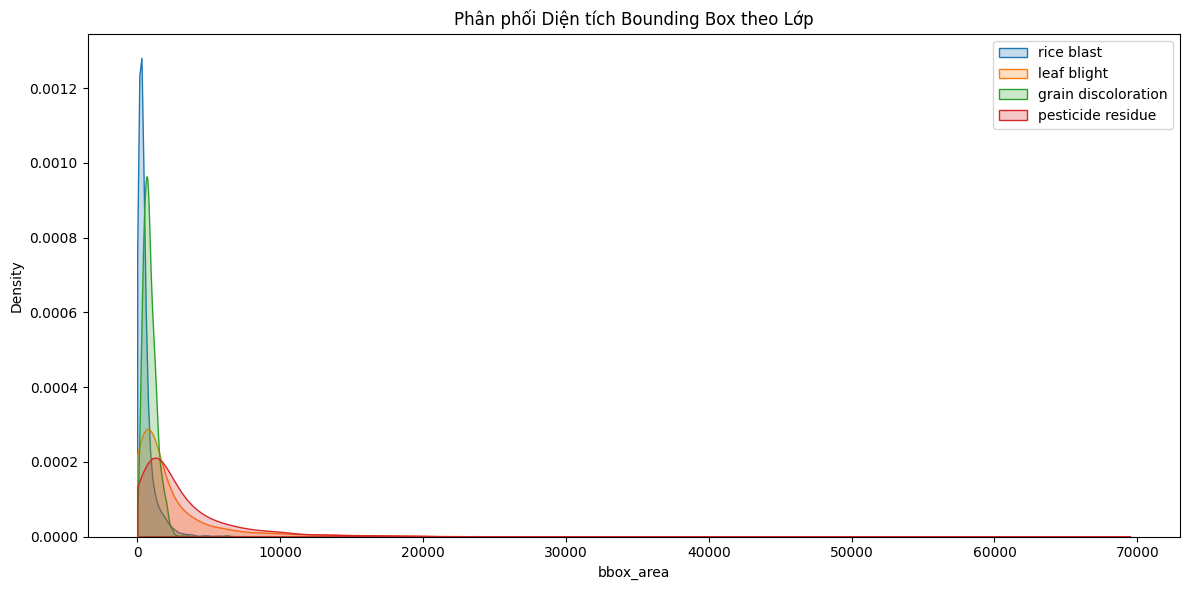

In [ ]:
plt.figure(figsize=(12, 6))
for cls in df['category_name'].unique():
    sns.kdeplot(df[df['category_name'] == cls]['polygon_area'], label=cls, fill=True, clip=(0, None))
plt.title('Phân phối Diện tích Bounding Box theo Lớp')
plt.xlabel('bbox_area')
plt.legend()
plt.tight_layout()
plt.show()

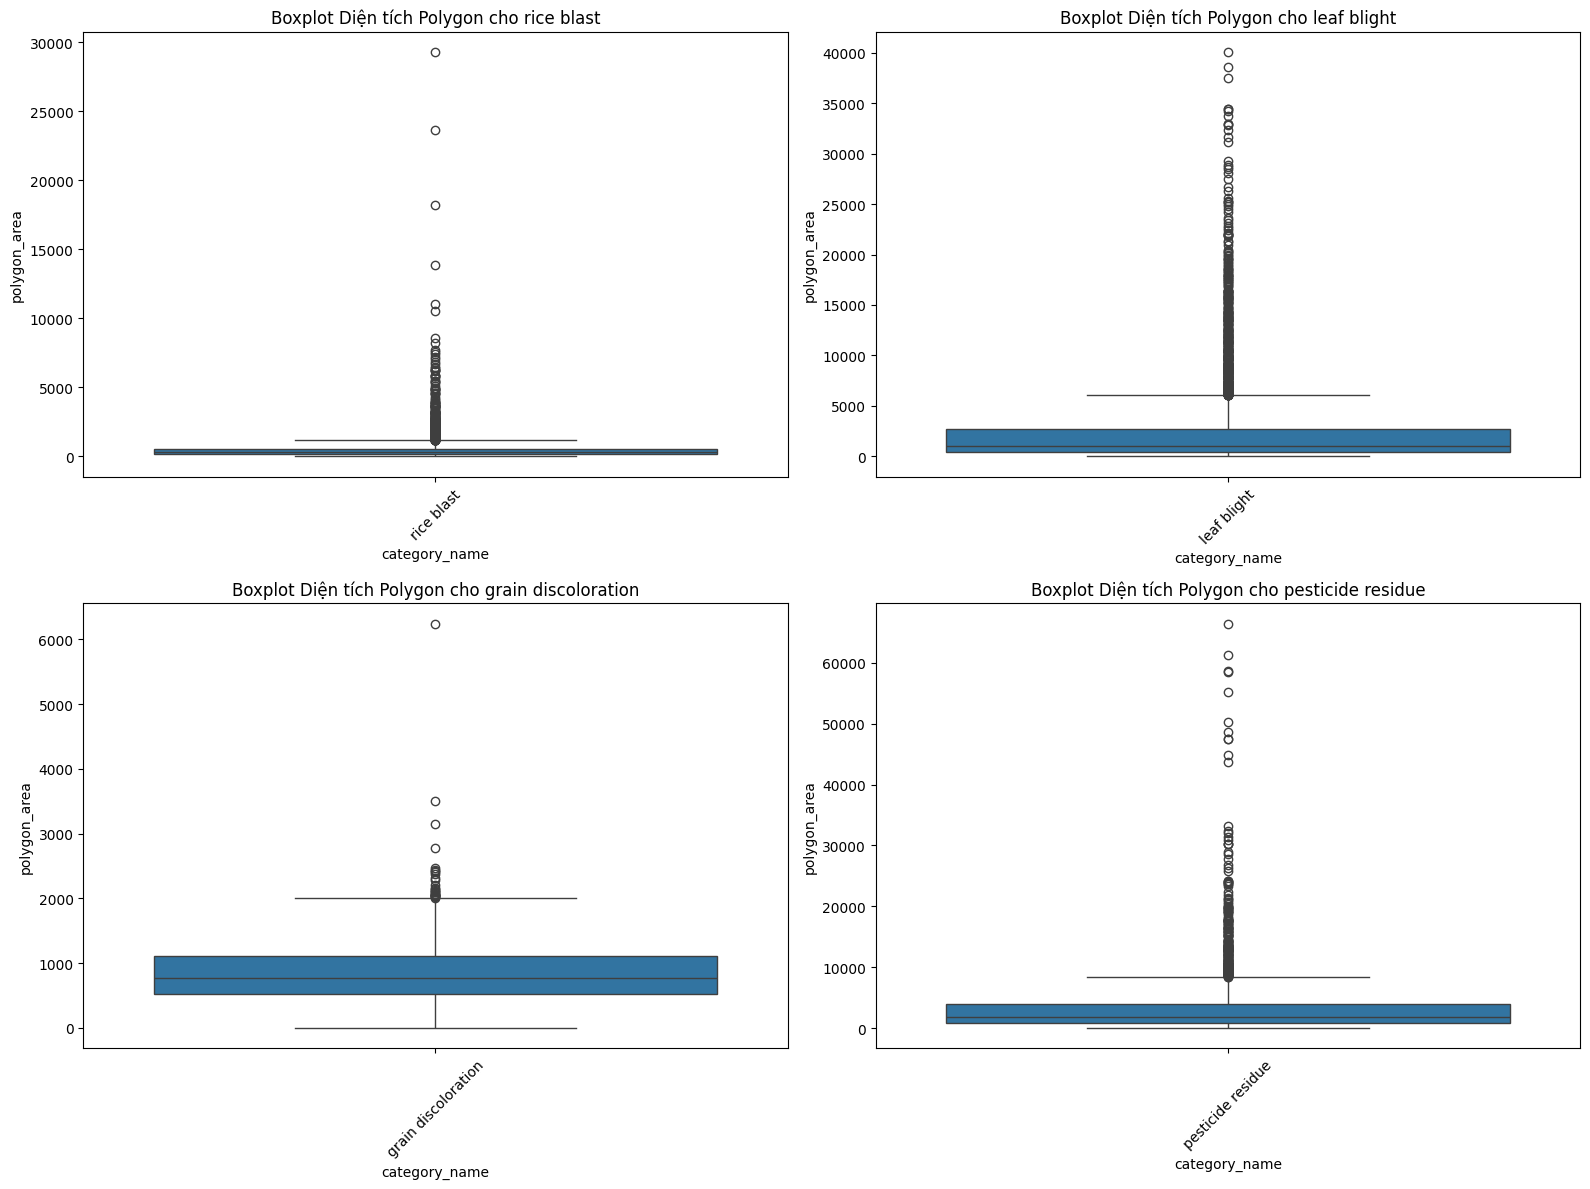

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pycocotools import mask as coco_mask

# ... (rest of your existing code remains unchanged) ...

# Function to calculate polygon area
def calculate_polygon_area(segmentation):
    """Calculates the area of a polygon using cv2.contourArea."""
    poly = segmentation # Assuming segmentation is a list with a single polygon
    pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
    if len(pts) >= 3: # contourArea requires at least 3 points
        area = cv2.contourArea(pts)
        return area
    else:
        return 0  # Or handle invalid segmentations as needed

# Calculate polygon areas and add as a new column to the DataFrame
df['polygon_area'] = df['segmentation'].apply(calculate_polygon_area)


# Get unique categories:
categories = df['category_name'].unique()

# Create a 2x2 grid for subplots:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted figsize

# Plot each category's boxplot in a separate subplot:
for i, category in enumerate(categories):
    row = i // 2  # Calculate subplot row
    col = i % 2   # Calculate subplot column
    ax = axes[row, col]  # Get the current subplot

    # Use 'polygon_area' instead of 'bbox_area'
    sns.boxplot(data=df[df['category_name'] == category], x='category_name', y='polygon_area', ax=ax)
    ax.set_title(f'Boxplot Diện tích Polygon cho {category}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
max_area = df['polygon_area'].max()
min_area = df['polygon_area'].min()
mean_area = df['polygon_area'].mean()
count = df['polygon_area'].count()
print(f"Số lượng polygon: {count}")
print(f"Giá trị tối đa của polygon_area: {max_area}")
print(f"Giá trị tối thiểu của polygon_area: {min_area}")
print(f"Giá trị trung bình của polygon_area: {mean_area}")

Số lượng polygon: 12568
Giá trị tối đa của polygon_area: 66461.5
Giá trị tối thiểu của polygon_area: 0.5
Giá trị trung bình của polygon_area: 1896.4527731439482


# Tứ phân vị cho diện tích của từng lớp

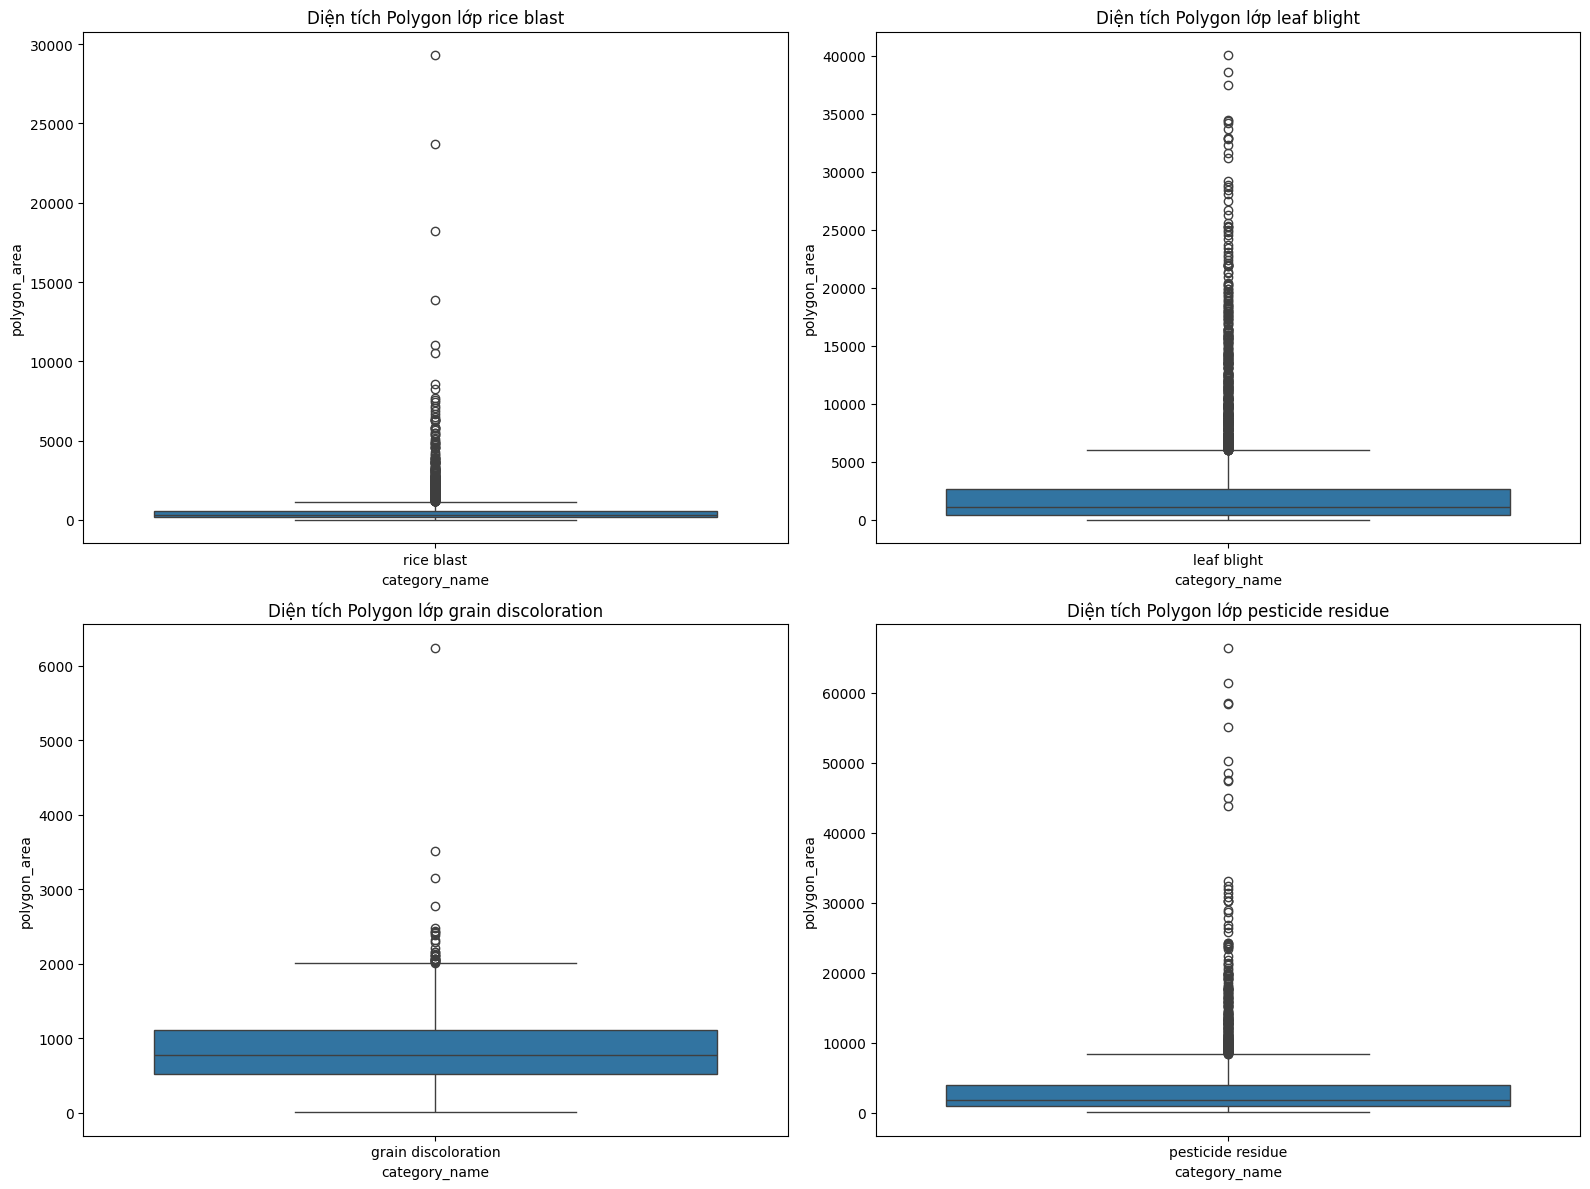

In [ ]:
# Get unique categories:
categories = df['category_name'].unique()

# Create a 2x2 grid for subplots:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted figsize

# Plot each category's boxplot in a separate subplot:
for i, category in enumerate(categories):
    row = i // 2  # Calculate subplot row
    col = i % 2   # Calculate subplot column
    ax = axes[row, col]  # Get the current subplot

    # Use 'polygon_area' instead of 'bbox_area'
    sns.boxplot(data=df[df['category_name'] == category], x='category_name', y='polygon_area', ax=ax)
    ax.set_title(f'Diện tích Polygon lớp {category}')
    ax.tick_params(axis='x')

plt.tight_layout()
plt.savefig('polygon_area_boxplot.png')
plt.show()

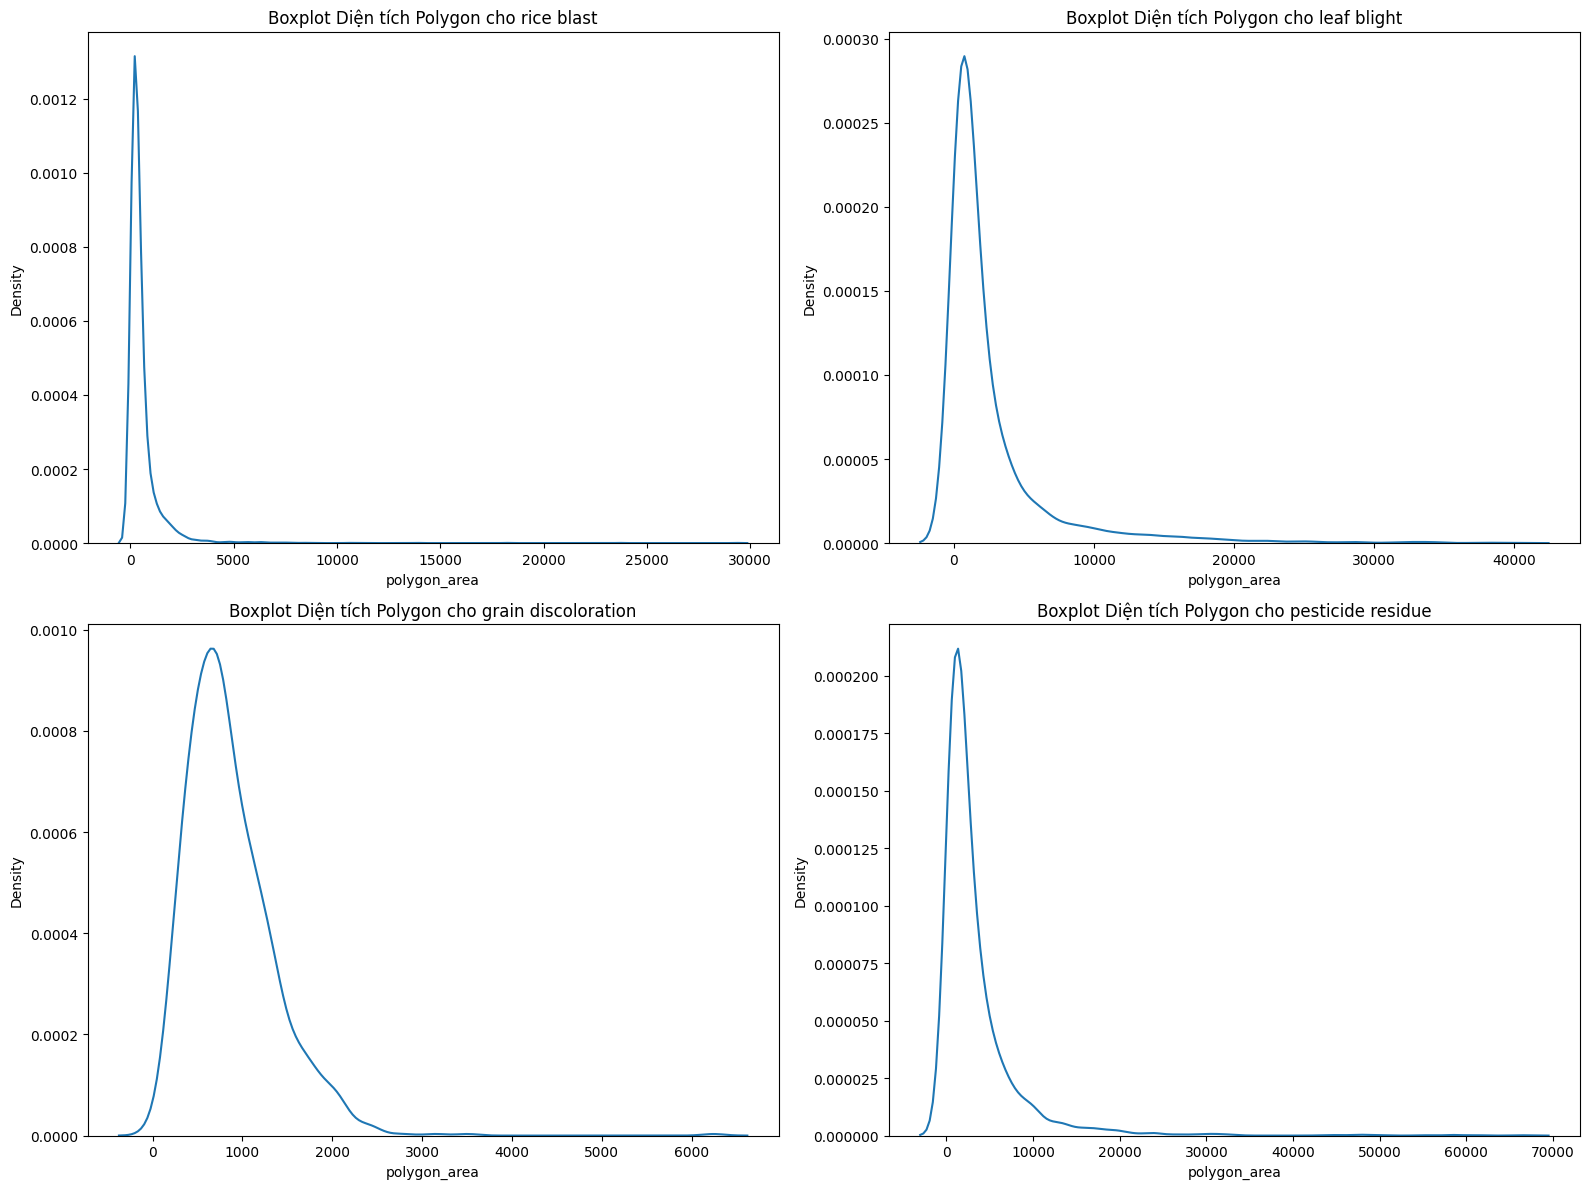

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pycocotools import mask as coco_mask

# ... (rest of your existing code remains unchanged) ...

# Function to calculate polygon area
def calculate_polygon_area(segmentation):
    """Calculates the area of a polygon using cv2.contourArea."""
    poly = segmentation  # Assuming segmentation is a list with a single polygon
    pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
    if len(pts) >= 3:  # contourArea requires at least 3 points
        area = cv2.contourArea(pts)
        return area
    else:
        return 0  # Or handle invalid segmentations as needed

# Calculate polygon areas and add as a new column to the DataFrame
df['polygon_area'] = df['segmentation'].apply(calculate_polygon_area)

# Get unique categories:
categories = df['category_name'].unique()

# Create a 2x2 grid for subplots:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted figsize

# Plot each category's boxplot in a separate subplot:
for i, category in enumerate(categories):
    row = i // 2  # Calculate subplot row
    col = i % 2   # Calculate subplot column
    ax = axes[row, col]  # Get the current subplot

    # Filter data for the current category
    category_data = df[df['category_name'] == category]

    # Use 'polygon_area' for the x-axis and remove the y-axis
    # Pass the DataFrame with 'polygon_area' as 'x'
    sns.kdeplot(data=category_data, x='polygon_area', ax=ax)
    ax.set_title(f'Boxplot Diện tích Polygon cho {category}')
    # ax.tick_params(axis='x', rotation=45)  # Removed unnecessary rotation for x-axis ticks

plt.tight_layout()
plt.savefig('polygon_area_plot.png')
plt.show()

# Diện tích Polygon

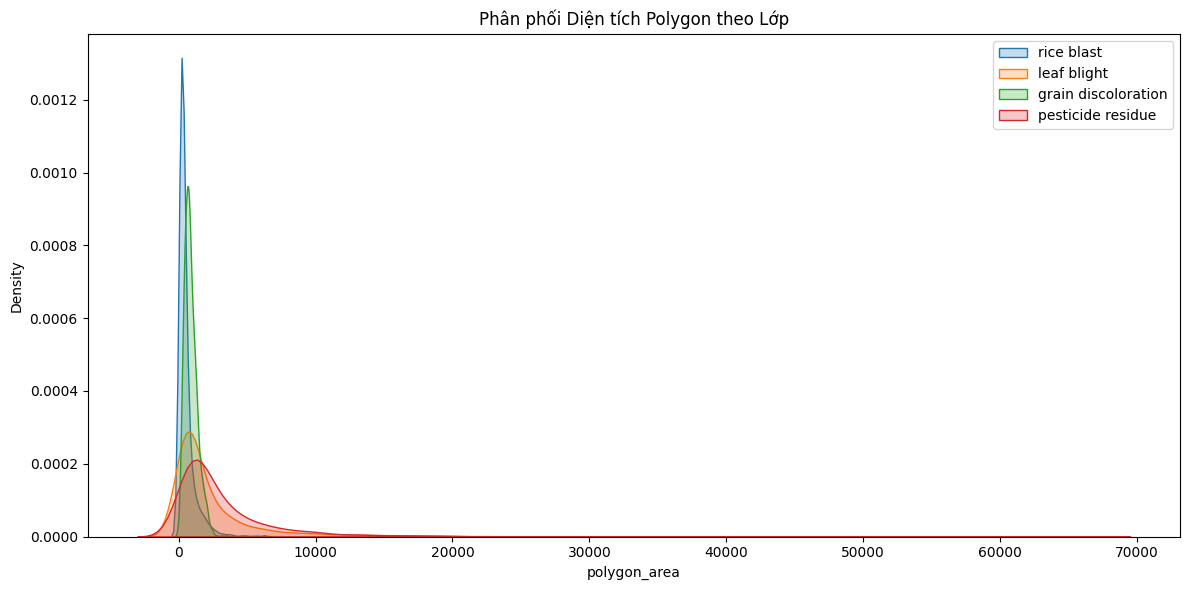

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pycocotools import mask as coco_mask

# ... (rest of your existing code remains unchanged) ...

# Function to calculate polygon area
def calculate_polygon_area(segmentation):
    """Calculates the area of a polygon using cv2.contourArea."""
    poly = segmentation  # Assuming segmentation is a list with a single polygon
    pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
    if len(pts) >= 3:  # contourArea requires at least 3 points
        area = cv2.contourArea(pts)
        return area
    else:
        return 0  # Or handle invalid segmentations as needed

# Calculate polygon areas and add as a new column to the DataFrame
df['polygon_area'] = df['segmentation'].apply(calculate_polygon_area)

# Create a single plot for all categories
plt.figure(figsize=(12, 6))
for category in df['category_name'].unique():
    sns.kdeplot(data=df[df['category_name'] == category], x='polygon_area', label=category, fill=True)

plt.title('–')
plt.xlabel('Diện tích')  # Changed x-axis label
plt.legend()
plt.tight_layout()
plt.show()

# Histogram số lượng instance (annotation_count) trên mỗi ảnh

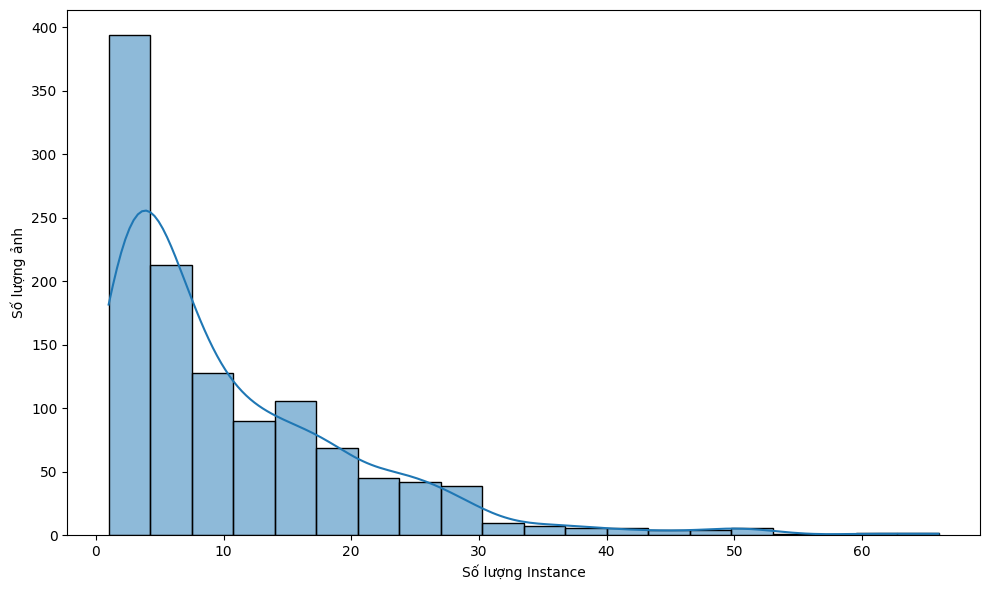

In [ ]:
# 5. Histogram số annotation trên mỗi ảnh
plt.figure(figsize=(10, 6))
sns.histplot(data=annotation_count, x='annotation_count', bins=20, kde=True)
plt.xlabel('Số lượng Instance')
plt.ylabel('Số lượng ảnh')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv('annotations_seg.csv')

# Tiền xử lý: tính bbox_area
df['bbox'] = df['bbox'].apply(eval)  # Assuming 'bbox' values are valid list representations
df['bbox_area'] = df['bbox'].apply(lambda x: x[2] * x[3])

# Tính số instance trên mỗi ảnh
annotation_count = df.groupby('file_name').size().reset_index(name='annotation_count')
df = df.merge(annotation_count, on='file_name')

# 1. Countplot số instance theo class
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='category_name', order=df['category_name'].value_counts().index)
plt.title('Số lượng Instance theo Lớp')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

# 2. KDE plot bbox_area theo class
plt.figure(figsize=(12, 6))
for cls in df['category_name'].unique():
    sns.kdeplot(df[df['category_name'] == cls]['bbox_area'], label=cls, fill=True, clip=(0, None))
plt.title('Phân phối Diện tích Bounding Box theo Lớp')
plt.xlabel('bbox_area')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Boxplot bbox_area theo class
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='bbox_area')
plt.title('Boxplot Diện tích Bounding Box theo Lớp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Jointplot width vs height
sns.jointplot(data=df, x='width', y='height', kind='scatter', hue='class', height=8)
plt.suptitle('Tương quan chiều rộng và chiều cao Bounding Box', y=1.02)
plt.show()

# 5. Histogram số annotation trên mỗi ảnh
plt.figure(figsize=(10, 6))
sns.histplot(data=annotation_count, x='annotation_count', bins=20, kde=True)
plt.title('Số lượng Instance trên mỗi ảnh')
plt.xlabel('annotation_count')
plt.tight_layout()
plt.show()

# 6. KDE plot image brightness nếu có cột 'image_mean'
if 'image_mean' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['image_mean'], fill=True)
    plt.title('Phân phối độ sáng trung bình ảnh (image_mean)')
    plt.tight_layout()
    plt.show()

# 7. Histogram image width & height nếu có cột
if 'image_width' in df.columns and 'image_height' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df['image_width'], bins=20, ax=axes[0])
    axes[0].set_title('Phân phối chiều rộng ảnh')
    sns.histplot(df['image_height'], bins=20, ax=axes[1])
    axes[1].set_title('Phân phối chiều cao ảnh')
    plt.tight_layout()
    plt.show()


KeyError: 'filename'